In [1]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))
sys.path.append(os.path.join(os.getcwd(), "molgen"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
# from molgen.dataloading.MolGraphBatchPreprocessor import MolGraph
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES


from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main
from mol_opt.mol_opt import MolOpt
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.ot_utils import encode_target
from mol_opt.ot_utils import FGW 

from molgen.dataloading.feat2smiles import feat2smiles
from molgen.dataloading.mol_drawer import MolDrawer
from molgen.metrics.Penalty import Penalty
from molgen.metrics.mol_metrics import MolMetrics

from rdkit.Chem import MolFromSmiles
from tensorboardX import SummaryWriter

import torch
import torch.nn.functional as F
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

/home/octav/gitrepos/tum-thesis


In [2]:
sys.argv = ["", "-cuda", "-pred_hidden", "150", "-model_type", "pointwise", "-one_batch_train"]
args = get_args()
args.n_epochs = 40 
args.init_model = "pointwise10-onebatch"
args.output_dir = "mol_opt/output_{}/".format(args.init_model)
args.tb_logs_dir = "mol_opt/logs_{}/".format(args.init_model)
args.init_decoder_model = "{}_decode".format(args.init_model)
args.batch_size = 6
args

Namespace(N_transformer=6, agg_func='sum', annealing_rate=0.0001, batch_norm=False, batch_size=6, connectivity=True, connectivity_hard=False, connectivity_lambda=0.025, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, euler_characteristic_penalty=True, euler_lambda=0.3, ffn_activation='LeakyReLU', init_decoder_model='pointwise10-onebatch_decode', init_model='pointwise10-onebatch', linear_out=False, model_type='pointwise', n_epochs=40, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=100, n_labels=1, n_layers=5, one_batch_train=True, ot_solver='emd', output_dir='mol_opt/output_pointwise10-onebatch/', pc_hidden=70, pred_hidden=150, sinkhorn_entropy=0.1, sinkhorn_max_it=10000, task='qed', tb_logs_dir='mol_opt/logs_pointwise10-onebatch/', valency=True, valency_hard=False, valency_lambda=0.07)

In [138]:
model = args.init_model
args.output_dir = f"mol_opt/output_{model}/"
model_iter = 947 

model_name = "model_{}_{}".format(model, model_iter)
print(args.output_dir + model_name)
model_decode_name = "model_{}_decode_{}".format(model, model_iter)
molopt, config = load_model(args.output_dir + model_name, MolOpt, args.device)
molopt, config

molopt_decoder, config_decoder = load_model(args.output_dir + model_decode_name, MolOptDecoder, args.device)
molopt_decoder, config_decoder

metrics = MolMetrics(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, False)
fgw_loss = FGW(alpha = 0.5)

molopt_module_list = torch.nn.ModuleList([molopt, molopt_decoder])

# molopt = MolOpt(args)
# molopt_decoder = MolOptDecoder(args)
print (molopt)
print (molopt_decoder)
print(molopt.args.model_type)

mol_opt/output_pointwise10-onebatch/model_pointwise10-onebatch_947
MolOpt(
  (GCN): GCN(
    (W_message_i): Linear(in_features=100, out_features=100, bias=False)
    (W_message_h): Linear(in_features=100, out_features=100, bias=False)
    (W_message_o): Linear(in_features=193, out_features=70, bias=True)
    (W_mol_h): Linear(in_features=70, out_features=100, bias=True)
    (W_mol_o): Linear(in_features=100, out_features=1, bias=True)
    (dropout_gcn): Dropout(p=0.0, inplace=False)
    (dropout_ffn): Dropout(p=0.0, inplace=False)
  )
  (opt0): Linear(in_features=70, out_features=100, bias=True)
  (opt1): Linear(in_features=100, out_features=70, bias=True)
)
MolOptDecoder(
  (fc1_SYMBOLS): Linear(in_features=70, out_features=100, bias=True)
  (fc2_SYMBOLS): Linear(in_features=100, out_features=64, bias=True)
  (fc1_CHARGES): Linear(in_features=70, out_features=100, bias=True)
  (fc2_CHARGES): Linear(in_features=100, out_features=5, bias=True)
  (fc1_BONDS): Linear(in_features=140, out_

In [139]:
train_data_loader = get_loader("iclr19-graph2graph/data/qed", "train_pairs", args.batch_size, True)

for i in train_data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [142]:
x_embedding = molopt.forward(X)
yhat_logits = molopt_decoder.forward(x_embedding, X, Y)
yhat_labels = molopt_decoder.discretize(*yhat_logits)
pred_pack = (yhat_labels, yhat_logits, Y.scope), Y 

target = Y.get_graph_outputs()
symbols_labels, charges_labels, bonds_labels = yhat_labels
symbols_logits, charges_logits, bonds_logits = yhat_logits

print (fgw_loss(*pred_pack, tau = 1).item()/args.batch_size)
metrics.measure_batch(pred_pack[0], target)

0.10935746630032857


{'molecular_disconnected_validity': 16.666666666666668,
 'molecular_validity': 0.0,
 'symbol_accuracy': 100.0,
 'connected_components': 2.0,
 'invalid_valency_nodes': 9.166666666666666}

In [147]:
bond_idx = 0
for mol_idx, (st, le) in enumerate(Y.scope):
    pred_symbols = symbols_labels[st:st+le]
    target_symbols = torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)
    
    symbols = symbols_labels[st:st+le]
    charges = charges_labels[st:st+le]
    bonds = bonds_labels[bond_idx:bond_idx+le*le].view(le, le, -1)
    bond_idx += le * le
    smiles = feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)
    print (smiles)

C.C=CC(=O)(CC[SH](CC)CC(=C)CNCCC)NC=O.N
C.C=CC.CNC(=O)CN(C)N=C(CCl)C(C)Cl
C=C12OC3(=O)N1C1C4C(C1F)=C=421N2C4COC(C)(C4C)C=3=12
C=NNC(CC)=C1NC(=O)N2=CC(=C)C2=C1CBr
C.C.C=CC1OCC123C(=O)NC1=NC=CS14COC=2OC43
CC=C1C2=CC2NC2OCO(C)C3CC4(C)(C3)OC1C24


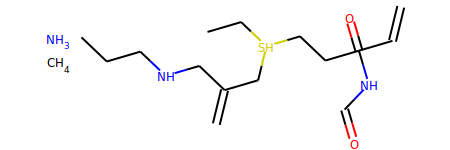

In [151]:
Chem.MolFromSmiles("C.C=CC(=O)(CC[SH](CC)CC(=C)CNCCC)NC=O.N", sanitize = False)

In [131]:
mol_idx = 0 
torch.argmax(target[mol_idx]['SYMBOLS'], dim=1)

tensor([0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0])

In [98]:
x_embedding.mean(axis = 0)

tensor([ 1.5784e+00, -1.4778e+00,  2.9719e-02, -9.0084e-01, -4.0965e+00,
         6.7646e-01, -1.5182e+00, -4.4093e-01, -9.7253e-01,  5.6442e+00,
         2.6422e+00, -3.0386e-01, -1.2958e+00, -1.2548e+00,  1.0840e+00,
         3.9257e-01, -2.1718e+00, -2.9173e-01, -1.1909e+00,  1.1134e+00,
        -1.6317e+00, -2.3049e+00,  1.2862e+00, -2.0604e+00,  4.4845e-03,
         8.8055e-01, -2.7253e+00,  9.2962e-01,  9.4172e-01, -2.4333e+00,
         2.9425e+00, -1.4029e+00, -7.1035e-01, -5.0024e-01,  4.7362e+00,
         5.8803e-01, -1.4083e+00,  4.2653e+00, -8.2459e-01,  9.4996e-01,
        -1.7489e+00,  8.7643e-01, -2.7810e-01, -1.0327e+00, -2.1070e-01,
        -8.5311e-01, -6.6335e-01, -1.8859e+00,  6.8191e-01,  5.5339e-01,
         2.8356e-01,  1.5098e+00, -1.1300e+00,  2.9961e+00, -1.2073e+00,
         7.9512e-01, -2.2092e+00,  2.0049e+00, -1.6072e-01,  2.3789e+00,
         2.0830e+00, -1.1199e+00,  1.7077e+00, -3.4699e+00,  4.7145e+00,
        -9.6422e-01,  1.0087e+00,  6.7723e-01, -3.6

In [99]:
(x_embedding.mean(axis = 0) / x_embedding.std(axis = 0)).abs().max()

tensor(1.1238, device='cuda:0', grad_fn=<MaxBackward1>)

In [100]:
x_embedding

tensor([[-2.0708,  4.6554, -0.6540,  ...,  0.6954,  4.0516, -2.4372],
        [ 3.3339,  2.2585, -2.8519,  ...,  3.2274, -2.9499, -3.2438],
        [ 0.1623, -1.7498, -1.3990,  ...,  3.5490, -3.9523, -0.3967],
        ...,
        [ 0.0863, -0.9068,  1.5183,  ...,  0.3134, -2.3497,  0.3462],
        [-0.0434, -0.1536,  0.7125,  ...,  0.9650, -2.4842,  0.2706],
        [ 0.3282, -2.6474, -0.6260,  ...,  1.3609, -2.6019,  0.0728]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [107]:
target_smiles = [Chem.MolToSmiles(y) for y in Y.rd_mols]
initial_smiles = [Chem.MolToSmiles(y) for y in X.rd_mols]

# uncomment for tensorboard
tb_writer = SummaryWriter(logdir = args.tb_logs_dir)
mol_drawer = MolDrawer(tb_writer, SYMBOLS, BOND_TYPES, FORMAL_CHARGES)
mol_drawer.visualize_batch(pred_pack[0], target_smiles, model_iter, initial_smiles, text="test")

CC1C(C=CC2(=O)C3(C)C(=O)C324CCN4)C1CSC(N)=CN
O=C12N3CC14C315(Cl)=C3=C6(Cl)=C78CC=69=C71(=C=825)N=3=491CN1
CC1234CC5(O1)N1678C9C%10%11C9%12C219N%101C(CC36)C1F12C3O4C17(=O)C3%11%125298
CC123NC45678N=C4C49C5=CN6=C56C47Br4C=5=8C4961N2C3=O
O=C12CO34C56C7O8C9%10%11%12%13=C%14C9%15=C=7=%10C=1=%118537(C(C=C1SC(N2)=N16)O%127)=C=%14=%13%154
C=C12C34=CN5C6(O)C78O9C(O)C%10%11%12C%13C6%14C3%106%15C4C=1%11C=61C597%15C%138%1412%12


In [149]:
feat2smiles(SYMBOLS, FORMAL_CHARGES, BOND_TYPES, symbols, charges, bonds, False)

'C=C.C=CC(=C)OC.CC1(C)CC(N)CCO1.COC'

In [31]:
tau = 1
symbols_nll, charges_nll, bonds_nll = F.gumbel_softmax(tau = tau, dim=1, logits = symbols_logits), F.gumbel_softmax(tau=tau,dim=1,logits=charges_logits), F.gumbel_softmax(tau=tau,dim=1, logits = bonds_logits)

<BarContainer object of 64 artists>

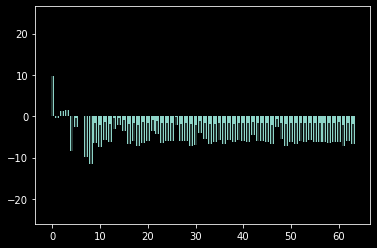

In [32]:
means = symbols_logits.mean(axis = 0).cpu().detach().numpy()
stds = symbols_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(SYMBOLS)), means, yerr = stds)

<BarContainer object of 5 artists>

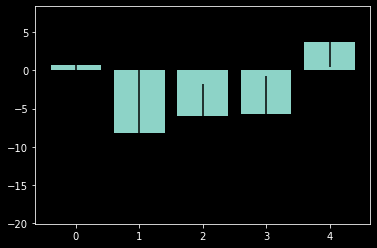

In [33]:
means = bonds_logits.mean(axis = 0).cpu().detach().numpy()
stds = bonds_logits.std(axis = 0).cpu().detach().numpy()
plt.bar(range(len(BOND_TYPES)), means, yerr = stds)

In [143]:
torch.argmax(symbols_logits/0.001, axis = 1)

tensor([3, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,
        0, 0, 0, 7, 0, 0, 1, 0, 0, 7, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 4,
        0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 8, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        3, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [127]:
torch.argmax(F.gumbel_softmax(tau = 1, dim=1, logits = symbols_logits), axis = 1)
# torch.argmax(F.softmax(symbols_logits, dim = 1), axis = 1)

tensor([ 3,  2,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  6,  2,  1,  0,  0,  0,  7,  0,  0,  1,  0,  0,  7,  0,  0,
         0,  1,  0,  0,  6,  0,  0,  0,  1,  0,  0, 31,  0,  0,  0,  1,  0,  0,
         0, 47,  0,  0,  0,  2,  0,  2,  0,  1,  0,  0,  0,  8,  1,  0,  1,  0,
         0,  0,  0,  0,  0,  1,  0,  2,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  2,  3,  0,  2,  2,  2,  2,  0,  0,  0,  0,  0,  2,
         0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')

In [487]:
symbols_logits

tensor([[ -5.6780,   5.8952,  11.1889,  ..., -30.1208, -24.6337, -29.3355],
        [  3.3820,   2.1068,   0.4773,  ..., -16.3992, -14.7082, -15.7533],
        [ 10.6218,  -3.9060,   2.7497,  ..., -25.2562, -22.3782, -23.9039],
        ...,
        [ -4.1295,  10.8501,   6.6254,  ..., -29.0132, -24.3605, -28.5342],
        [  1.3812,   1.8645,   3.5352,  ..., -14.6826, -12.6566, -14.3107],
        [ 15.3534,  -7.1076,   3.8551,  ..., -33.5627, -29.6926, -32.5803]],
       device='cuda:0', grad_fn=<CatBackward>)

In [450]:
symbols_logits

tensor([[-33.2072,  27.2852,  46.7486,  ..., -53.0982, -52.8863, -60.3321],
        [ 14.6311,  -2.3156,   5.4598,  ..., -38.3053, -37.1660, -37.8885],
        [ 29.0675,  -0.7931,   0.9326,  ..., -53.3210, -53.6145, -52.3648],
        ...,
        [-34.2030,  32.3473,  48.3066,  ..., -58.3251, -58.8557, -67.2379],
        [ 16.6271,   2.5583,  -1.8918,  ..., -32.2702, -33.5266, -32.6264],
        [ 50.9242,  -7.7810,  13.9462,  ..., -82.7819, -85.8249, -87.6142]],
       device='cuda:0', grad_fn=<CatBackward>)

In [451]:
F.gumbel_softmax(tau = 0.1, dim=1, logits = symbols_logits)

tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.8026e-45,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
symbols_logits.shape

In [ ]:
symbols_labels

In [ ]:
bonds_labels.unique(return_counts = True)

# inspect module parameters

In [ ]:
molopt_decoder.fc1_SYMBOLS

In [ ]:
molopt_decoder.fc2_SYMBOLS(F.leaky_relu(molopt_decoder.fc1_SYMBOLS(x_embedding)))

In [ ]:
x_embedding